In [ ]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import osmnx as ox
import pandas as pd
import gtfs_kit as gk
from glob import glob
import os
from pathlib import Path
import pandana as pdna
import h3
import pydeck as pdk
import requests

In [ ]:
# load bus_stops

zip_file = glob(os.path.join('.', 'GTFS', '*.zip'))[0]
zip_file = Path(zip_file)
# Cargar los datos GTFS desde un archivo .zip
gtfs_data = gk.read_feed(zip_file, dist_units='km')

# Convertir los datos GTFS a DataFrames
stops_df = gtfs_data.stops
# routes_df = gtfs_data.routes
# trips_df = gtfs_data.trips
# stop_times_df = gtfs_data.stop_times
# calendar_df = gtfs_data.calendar
# calendar_dates_df = gtfs_data.calendar_dates

gtfs_data.validate()

,type,message,table,rows
0,warning,"Repeated pair (trip_id, departure_time)",stop_times,"[873334, 873558, 873670, 873782, 873894, 87467..."


In [ ]:
def nodes_edges_to_net_format(nodes_gdf, edges_gdf):

    nodes = pd.DataFrame(
        {
            'osmid': nodes_gdf['osmid'].astype(int),
            'lat' : nodes_gdf.geometry.y.astype(float),
            'lon' : nodes_gdf.geometry.x.astype(float),
            'y' : nodes_gdf.geometry.y.astype(float),
            'x' : nodes_gdf.geometry.x.astype(float),
        }
    )
    
    nodes['id'] = nodes['osmid'].values

    nodes = gpd.GeoDataFrame(data=nodes, geometry=nodes_gdf.geometry)
    nodes.reset_index(inplace=True)
    nodes.drop_duplicates(inplace=True)

    edges = pd.DataFrame(
        {
            'u': edges_gdf['src'].astype(int),
            'v': edges_gdf['dst'].astype(int),
            'from': edges_gdf['src'].astype(int),
            'to': edges_gdf['dst'].astype(int),
            'osmid': edges_gdf['osmid'].astype(int),
            'length': edges_gdf['length'].astype(float)
        }
    )

    edges['key'] = 0
    edges['key'] = edges['key'].astype(int)
    edges = gpd.GeoDataFrame(data=edges, geometry=edges_gdf.geometry)
    edges.set_index(['u', 'v', 'key'], inplace=True)
    edges.drop_duplicates(inplace=True)
    return nodes, edges

In [ ]:
def make_network(nodes_gdf, edges_gdf):
    net = None
    # Redirige la salida estándar a /dev/null (un objeto nulo)
    with open(os.devnull, 'w') as fnull:
        # Redirige la salida estándar a /dev/null temporalmente
        old_stdout = os.dup(1)
        os.dup2(fnull.fileno(), 1)
        # Tu código para crear la red de Pandana aquí
        net = pdna.Network(
            nodes_gdf['lon'],
            nodes_gdf['lat'],
            edges_gdf['from'],
            edges_gdf['to'],
            edges_gdf[['length']]
        )
        # Restaura la salida estándar original
        os.dup2(old_stdout, 1)
    return net

In [ ]:
nodes = gpd.read_parquet('./data/actual_nodes.parquet')
edges = gpd.read_parquet('./data/actual_edges.parquet')

(a,b) = nodes_edges_to_net_format(nodes, edges)
net = make_network(a,b)

In [ ]:
stops_gdf = gpd.GeoDataFrame(stops_df, geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat))

In [ ]:
def make_grid_points_gdf(gdf, x_spacing, y_spacing):
    gdf = gdf.copy()
    # if gdf.crs is None:
    #     gdf.crs = 'EPSG:4326'
    gdf.set_crs(4326)
    gdf.to_crs('32718', inplace=True)

    xmin, ymin, xmax, ymax = gdf.total_bounds
    xcoords = [c for c in np.arange(xmin, xmax, x_spacing)]
    ycoords = [c for c in np.arange(ymin, ymax, y_spacing)]

    coordinate_pairs = np.array(np.meshgrid(xcoords, ycoords)).T.reshape(-1, 2)
    geometries = gpd.points_from_xy(coordinate_pairs[:,0], coordinate_pairs[:,1])

    pointdf = gpd.GeoDataFrame(geometry=geometries, crs=gdf.crs)

    pointdf.to_crs('4326', inplace=True)
    return pointdf

x_spacing = 50
y_spacing = 50
grid_points = make_grid_points_gdf(stops_gdf, x_spacing, y_spacing)

In [ ]:
talcahuano_poly = gpd.read_file('./data/talcahuano')
talcahuano_poly = requests.get(f'{self.url}')
# talcahuano_poly.to_crs(crs='EPSG:4326', inplace=True)
talcahuano_poly.to_crs(4326, inplace=True)
talcahuano_poly = talcahuano_poly[['geometry']]

In [8]:
grid_points = gpd.overlay(grid_points, talcahuano_poly)

In [9]:
max_distance=25000 ## in meters
num_pois = 1

category = 'bus_stops'
net.set_pois(category=category, maxdist = max_distance, maxitems=num_pois, x_col=stops_gdf['geometry'].x, y_col=stops_gdf['geometry'].y)
accessibility = net.nearest_pois(distance = max_distance, category=category, num_pois=num_pois)

In [10]:
grid_points['osmid'] = net.get_node_ids(grid_points['geometry'].x, grid_points['geometry'].y)

In [11]:
grid_with_nearest_node = pd.merge(grid_points, net.nodes_df, on='osmid')

def distance_between_points(row):
    origin_x = row['geometry'].x
    origin_y = row['geometry'].y
    destination_x = row['x']
    destination_y = row['y']
    return ox.distance.great_circle(origin_y, origin_x, destination_y, destination_x)

grid_with_nearest_node['distance_to_nearest_node'] = grid_with_nearest_node.apply(distance_between_points, axis=1)

In [12]:
accessibility = pd.merge(grid_with_nearest_node, accessibility, on='osmid').rename(columns={1: 'distance_to_nearest_poi'})
accessibility['distance'] = accessibility['distance_to_nearest_node'] + accessibility['distance_to_nearest_poi']

In [13]:
# fig, ax = plt.subplots(figsize=(10,10))
# accessibility.plot(column='distance', legend=True, cmap='RdYlGn_r', ax=ax, vmax=)
# edges.plot(ax=ax, color='blue', markersize=0.5, alpha=0.2)

In [14]:
def plot_nearest_amenity(accessibility, n ,gdf: gpd.GeoDataFrame):
    accessibility = accessibility.fillna(999999)
    fig, ax = plt.subplots(figsize=(10,10))
    accessibility_nodes = pd.merge(net.nodes_df, accessibility, how='left', on='osmid').rename(columns={1:'distance'}).reset_index()
    accessibility_nodes = gpd.GeoDataFrame(accessibility_nodes, geometry=gpd.points_from_xy(accessibility_nodes['x'], accessibility_nodes['y']))
    accessibility_nodes.plot(ax=ax, vmin=0, vmax=500, c ='distance', cmap='RdYlGn', legend=True)
    gdf.plot(ax=ax, color='blue', markersize=1, label='Bus Stops')
    bbox = accessibility_nodes.total_bounds
    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])
    # ax.set_facecolor('k');
    ax.legend()
    return fig
# stops_gdf.plot()
# fig = plot_nearest_amenity(accessibility, num_pois, stops_gdf)

In [15]:
APERTURE_SIZE = 10
hex_col = f'hex{APERTURE_SIZE}'

distance = accessibility.copy()

distance[hex_col] = distance.apply(lambda p: h3.latlng_to_cell(p.geometry.y,p.geometry.x,APERTURE_SIZE),1)

distance_m = distance[[hex_col, 'distance']].groupby(hex_col).mean().reset_index()

In [16]:
max_distance = distance_m['distance'].max()
distance_m = distance_m.fillna(max_distance)

In [17]:
speed_kmh = 4 # km/h
speed = speed_kmh * 1000 / 60 # m/min
distance_m['mins'] = distance_m['distance']/speed
distance_m['display_text'] = distance_m['mins'].apply(lambda x: f"Accessibility: {x:.0f} mins")

In [18]:
import matplotlib.colors as mp_color
import matplotlib.cm as cmx

In [19]:
def create_custom_cmap(values):
    # Define the colors for the colormap
    colors = ['#42f5da', '#7DDA58', '#DECE58', '#DE8758', '#DE5858']

    # Create the colormap object
    cmap = mp_color.ListedColormap(colors)

    # Define the color boundaries for the colormap
    boundaries = values

    # Create the normalization object
    norm = mp_color.BoundaryNorm(boundaries, len(colors))

    return cmap, norm

def get_color_value(value, cmap, norm):
    # Normalize the value to the range of the colormap
    norm_value = norm(value)

    # Get the color value from the colormap
    color = cmap(norm_value)

    scaled_colors = list(map(lambda x: int(x*255), color[:3]))
    scaled_alpha = int(color[3]*100)

    scaled_colors += [scaled_alpha]
    return scaled_colors


def colormap_dataframe(df, value_col, cmap, norm, max_val=None):

    xdf = df.copy()
    xdf['color'] = xdf[f'{value_col}'].apply(lambda x: get_color_value(x, cmap, norm))
    xdf[['R', 'G', 'B', 'A']] = pd.DataFrame(xdf['color'].to_list())
    xdf = xdf.drop(['color'], axis=1)

    xdf[value_col] = xdf[value_col].round(1)

    return xdf

def create_h3_hex_layer(df):

    # Define a layer to display on a map
    layer = pdk.Layer(
        "H3HexagonLayer",
        df,
        pickable=True,
        stroked=True,
        filled=True,
        extruded=False,
        get_hexagon=hex_col,
        get_fill_color="[R, G, B, A]"
    )

    return layer

In [20]:
from shapely.geometry import Polygon

bbox = nodes.total_bounds
minx, miny, maxx, maxy = bbox
bounding_box_points = [
    (minx, miny),  # Esquina inferior izquierda
    (maxx, miny),  # Esquina inferior derecha
    (maxx, maxy),  # Esquina superior derecha
    (minx, maxy)   # Esquina superior izquierda
]
bounding_box_points

# Crear un polígono a partir de los puntos
bbox_polygon = Polygon(bounding_box_points)

# Crear un GeoDataFrame a partir del polígono
bbox = gpd.GeoDataFrame(index=[0], geometry=[bbox_polygon], crs="EPSG:4326")

In [23]:
station_layer = pdk.Layer(
    'GeoJsonLayer',
    data=stops_gdf.to_json(),
    stoked=True,
    getLineColor=[158, 2, 38,100],
    getLineWidth=10,
    filled=True,
    get_fill_color=[158, 2, 38,100],
    extruded=True,
    get_elevation=30,
    pickable=True
)

## Apply the colormap to the dataframe
cmap, norm = create_custom_cmap(np.linspace(0, 15, 5))
xdf = colormap_dataframe(df=distance_m, value_col='mins', cmap=cmap, norm=norm)

## Now create a H3HexagonLayer
layer = create_h3_hex_layer(xdf)

# Set the viewport location
x,y = bbox.centroid.x.values[0], bbox.centroid.y.values[0]
view_state = pdk.ViewState(latitude=y, longitude=x, zoom=11, bearing=0, pitch=45)

tooltip = {
        "html": "{display_text}",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

# # Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)
r.to_html('h3_hex_layer.html', iframe_width=900)

C:\Users\Asus\AppData\Local\Temp\ipykernel_11192\3506902237.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x,y = bbox.centroid.x.values[0], bbox.centroid.y.values[0]


In [24]:
from shapely.geometry import Polygon

# Función para convertir código H3 a un polígono de Shapely
def h3_to_polygon(hex_code):
    boundary = h3.cell_to_boundary(hex_code)
    boundary_corrected = [(lat, lon) for lon, lat in boundary]
    return Polygon(boundary_corrected)

# Crear una nueva columna en el DataFrame con la geometría de cada hexágono
distance_m['geometry'] = distance_m[hex_col].apply(h3_to_polygon)

# Convertir el DataFrame en un GeoDataFrame
gdf = gpd.GeoDataFrame(distance_m, geometry='geometry')

(-73.17384076943642,
 -73.00489741667226,
 -36.80525600389961,
 -36.59374786373437)

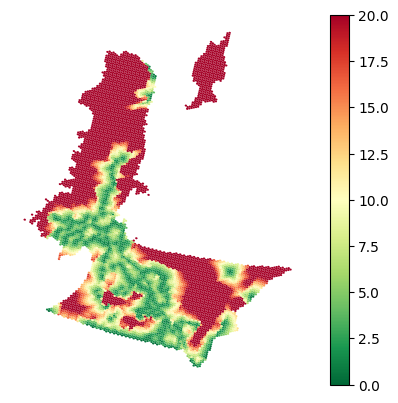

In [28]:
gdf.plot(column='mins', vmin=0, vmax=20, cmap='RdYlGn_r', legend=True)
plt.axis('off')

In [61]:
gdf.set_crs(epsg=4326, inplace=True)

,hex10,distance,mins,display_text,geometry
0,8ab2d8680097fff,713.779767,10.706697,Accessibility: 11 mins,"POLYGON ((-73.04462 -36.76887, -73.04412 -36.7..."
1,8ab2d86800b7fff,761.770289,11.426554,Accessibility: 11 mins,"POLYGON ((-73.04437 -36.7678, -73.04387 -36.76..."
2,8ab2d8680197fff,832.613778,12.489207,Accessibility: 12 mins,"POLYGON ((-73.04511 -36.76592, -73.04462 -36.7..."
3,8ab2d868019ffff,821.118238,12.316774,Accessibility: 12 mins,"POLYGON ((-73.04412 -36.76673, -73.04362 -36.7..."
4,8ab2d86801b7fff,868.331920,13.024979,Accessibility: 13 mins,"POLYGON ((-73.04487 -36.76485, -73.04437 -36.7..."
...,...,...,...,...,...
7730,8ab2dab6dd97fff,3003.477652,45.052165,Accessibility: 45 mins,"POLYGON ((-73.1303 -36.66895, -73.1298 -36.668..."
7731,8ab2dab6dd9ffff,2734.061519,41.010923,Accessibility: 41 mins,"POLYGON ((-73.12931 -36.66977, -73.12881 -36.6..."
7732,8ab2dab6dda7fff,2920.014677,43.800220,Accessibility: 44 mins,"POLYGON ((-73.12881 -36.66763, -73.12831 -36.6..."
7733,8ab2dab6ddaffff,2814.914841,42.223723,Accessibility: 42 mins,"POLYGON ((-73.12781 -36.66845, -73.12732 -36.6..."


In [27]:
filename = f'./data/accessibility_{category}_actual'
gdf.to_file(filename)
import shutil
shutil.make_archive(filename, 'zip', filename)

C:\Users\Asus\AppData\Local\Temp\ipykernel_11192\1230459586.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(filename)
c:\Users\Asus\Dev\transporte-publico\.venv\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
c:\Users\Asus\Dev\transporte-publico\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'display_text' to 'display_te'
  ogr_write(


'c:\\Users\\Asus\\Dev\\transporte-publico\\data\\accessibility_bus_stops_actual.zip'

In [41]:
gdf_classified = gpd.sjoin_nearest(grid_points, level_curves.to_crs('4326'), how="left", distance_col="distance")

c:\Users\Asus\Dev\transporte-publico\.venv\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


<Axes: >

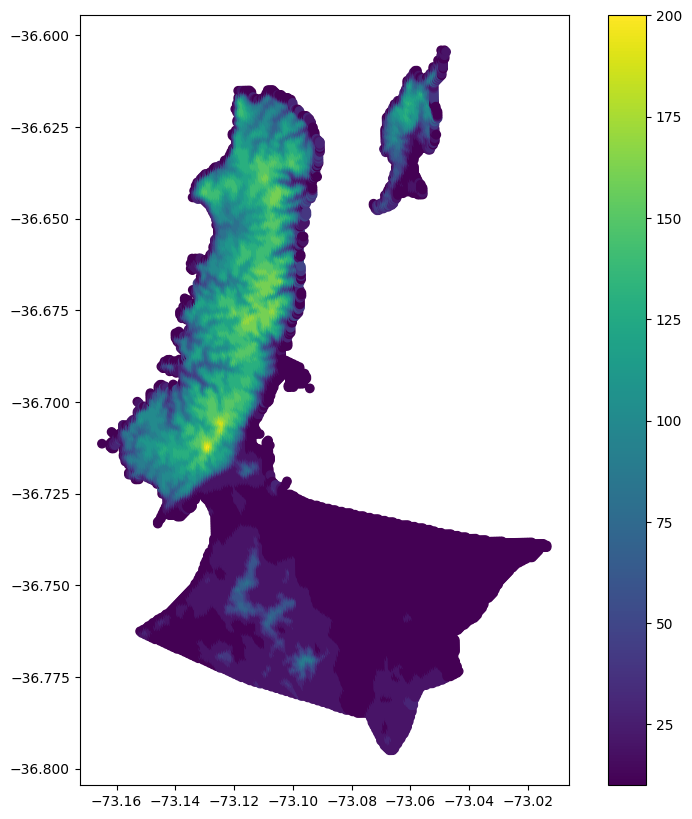

In [42]:
gdf_classified.plot(column='ELEV', legend=True, cmap='viridis', figsize=(10,10))

In [47]:
gdf_classified.head()

,geometry,osmid,index_right,fid_1,ID,ELEV,Shape_Leng,distance
0,POINT (-73.16496 -36.71136),1814480647,1206,10868.0,10867,10.0,71.109975,0.003124
1,POINT (-73.16214 -36.71222),1814480647,1212,10909.0,10908,10.0,12.500000,0.000755
2,POINT (-73.16216 -36.71132),1814480647,1206,10868.0,10867,10.0,71.109975,0.000326
3,POINT (-73.16157 -36.71266),1814480647,1217,10934.0,10933,10.0,12.500000,0.000256
4,POINT (-73.16159 -36.71176),1814480647,1209,10900.0,10899,20.0,234.914342,0.000322


In [46]:
distance

,geometry,osmid,x,y,distance_to_nearest_node,distance_to_nearest_poi,distance,hex9
0,POINT (-73.16496 -36.71136),1814480647,-73.156940,-36.713525,754.085672,1811.16394,2565.249613,89b2dab4cdbffff
1,POINT (-73.16214 -36.71222),1814480647,-73.156940,-36.713525,485.593451,1811.16394,2296.757392,89b2dab4cc3ffff
2,POINT (-73.16216 -36.71132),1814480647,-73.156940,-36.713525,525.988629,1811.16394,2337.152570,89b2dab4cc3ffff
3,POINT (-73.16157 -36.71266),1814480647,-73.156940,-36.713525,423.597362,1811.16394,2234.761303,89b2dab4cc3ffff
4,POINT (-73.16159 -36.71176),1814480647,-73.156940,-36.713525,458.538868,1811.16394,2269.702808,89b2dab4cc3ffff
...,...,...,...,...,...,...,...,...
37248,POINT (-73.0148 -36.7387),1313598805,-73.035785,-36.755056,2608.504484,0.00000,2608.504484,89b2d86a337ffff
37249,POINT (-73.01422 -36.73959),1313598805,-73.035785,-36.755056,2578.818967,0.00000,2578.818967,89b2d86a337ffff
37250,POINT (-73.01423 -36.73914),1313598805,-73.035785,-36.755056,2611.735235,0.00000,2611.735235,89b2d86a337ffff
37251,POINT (-73.01366 -36.73958),1313598805,-73.035785,-36.755056,2616.872506,0.00000,2616.872506,89b2d86aecbffff
